In [18]:
import subprocess
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
# import CANN, extract_vtu_data
from CANN import CANN, BoundaryLayerDataset, custom_collate_fn, pad_sequence
from extract_vtu_data import extract_vtu_data
from eval_velocity import return_velocity
from extract_comp_info import extract_farfield_conditions
import torch
import datetime
import pickle


# define constants 
U_INF_INCOMP = 1
U_INF_COMP = 69.1687
MU_CONSTANT= 1.83463e-05
RHO = 1.13235
NU = MU_CONSTANT / RHO
PR_LAM = 0.72
PR_TURB = 0.9
GAMMA = 1.4
R = 287.05
T_INF = 297.62
MA_COMP = 0.2
MA_INCOMP = 0.195324
DOMAIN_LENGTH = 0.06096 + 0.3048

# mesh constants 
WIDTH = 65      # hard coded from mesh topology
HEIGHT = 65    # hard coded from mesh topology

input_data = np.load('input_data.pkl', allow_pickle=True)
#input_data = all_comp_data
dataset = BoundaryLayerDataset(input_data)
print(len(dataset))
# set index for MA0.21 BP 97500
index_test_run = [442, 446, 450, 454, 458, 462, 466, 470, 474]


1632


# Model with no pruneing (dense)

Running on cuda
Fold 1/10
Training on cuda
Epoch 1, Loss: 184.22666931152344
Epoch 2, Loss: 6.164923667907715
Epoch 3, Loss: 0.6348589062690735
Epoch 4, Loss: 0.2840588688850403
Epoch 5, Loss: 0.2936832010746002
Epoch 6, Loss: 0.29868584871292114
Epoch 7, Loss: 0.42541611194610596
Epoch 8, Loss: 0.4692012071609497
Epoch 9, Loss: 0.31866902112960815
Epoch 10, Loss: 0.3391735553741455
Epoch 11, Loss: 0.3444814085960388
Epoch 12, Loss: 0.5137742757797241
Epoch 13, Loss: 0.8084297776222229
Epoch 14, Loss: 0.315489262342453
Epoch 15, Loss: 0.5194509029388428
Epoch 16, Loss: 0.8584303855895996
Epoch 17, Loss: 0.43046391010284424
Epoch 18, Loss: 0.4640965461730957
Epoch 19, Loss: 4.447118759155273
Epoch 20, Loss: 7.4882354736328125
Epoch 21, Loss: 26.267580032348633
Epoch 22, Loss: 12.988239288330078
Epoch 23, Loss: 8.853320121765137
Epoch 24, Loss: 0.34407782554626465
Epoch 25, Loss: 1.0462185144424438
Epoch 26, Loss: 2.2032761573791504
Epoch 27, Loss: 0.3217228353023529
Epoch 28, Loss: 0.39

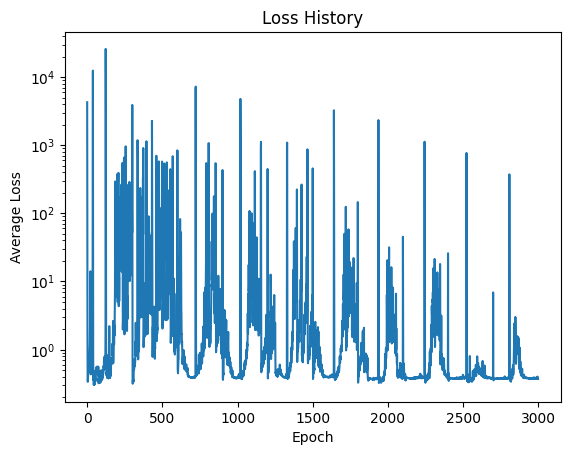

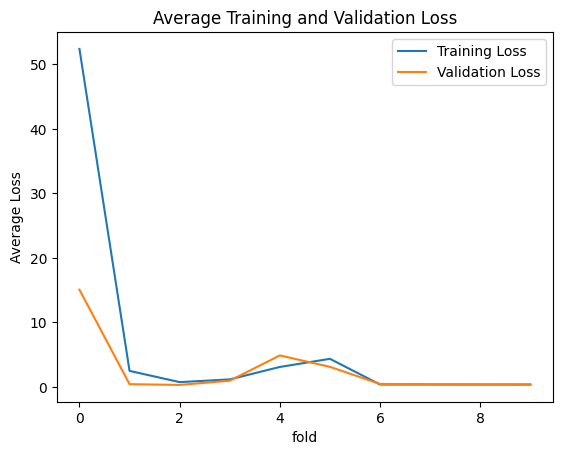

/tmp/ipykernel_11561/2788293592.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
/home/yiren/Desktop/blasius_ANN/CANN.py:241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Re_x = torch.tensor(Re_x, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/CANN.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dp_dx = torch.tensor(dp_dx, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/C

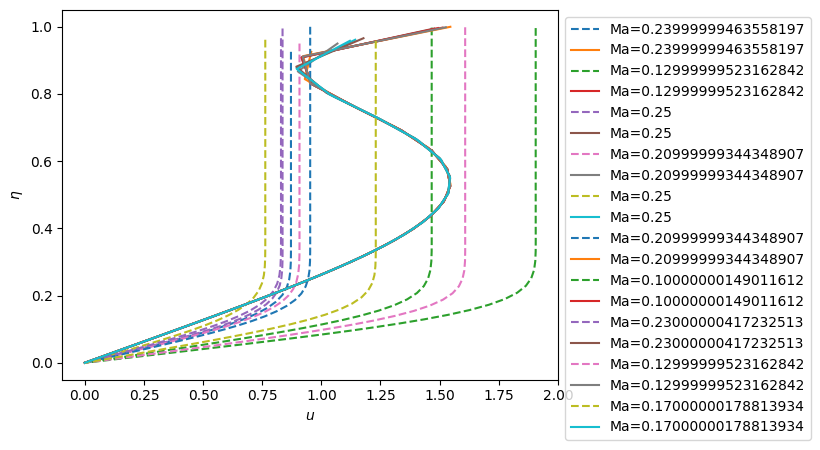

TypeError: CANN.evaluate() takes 2 positional arguments but 3 were given

In [6]:

############################################################################################################
###  Train the model
############################################################################################################

# define training params 
num_cv_folds = 10
epochs = 3000
learning_rate = 20e-1
step_size = 150
gamma = 0.9
prune_iter = 150
to_prune = False

# define model parameters 
alpha=20e-3
beta = 1
prune_threshold_min=1e-10
prune_threshold_max=1e20

torch.seed = 3407
model = CANN(alpha=alpha, beta=beta, prune_threshold_min=prune_threshold_min, prune_threshold_max=prune_threshold_max)
# train the model with cross validation (k-fold cross validation
los_history, train_ave_loss, val_ave_loss = model.train_with_cross_validation(dataset, num_folds=num_cv_folds, \
                                                                               epochs=epochs, learning_rate=learning_rate, \
                                                                                step_size=step_size, gamma=gamma, \
                                                                                to_prune=to_prune, prune_iter=prune_iter)

trained_weights, trained_biases = model.get_weights()
print('Trained weights:')
print(trained_weights)
print('Trained biases:')
print(trained_biases)
# save the model
cur_date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
torch.save(model.state_dict(), f"trained_model_{cur_date_time}.pth")
# save the loss history
np.save(f"loss_history_{cur_date_time}.npy", los_history)
np.save(f"train_ave_loss_{cur_date_time}.npy", train_ave_loss)
np.save(f"val_ave_loss_{cur_date_time}.npy", val_ave_loss)
# save the weights and biases
for i, weights in enumerate(trained_weights):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", weights)
for i, bias in enumerate(trained_biases):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", bias)

# save dataset
with open('dataset.pkl', 'wb') as f:
    pickle.dump(input_data, f)

# flatting loss history into 1d array 
los_history_flatten = [item for sublist in los_history for item in sublist]

# Plotting the loss history
plt.plot(los_history_flatten)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.yscale('log')
plt.savefig(f"loss_history_{cur_date_time}.png")
plt.show()

# Plotting the average training and validation loss
plt.plot(train_ave_loss, label='Training Loss')
plt.plot(val_ave_loss, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('fold')
plt.ylabel('Average Loss')
plt.legend()
plt.savefig(f"train_val_loss_{cur_date_time}.png")
plt.show()

# randomly select some 10 data from the dataset to evaluate the model
num_data = 10
np.random.seed(3407)
random_indices = np.random.choice(len(dataset), num_data, replace=False)
for idx in random_indices:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"Ma={mach}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Ma={mach}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()  


# evaluate the model with the test data
test_loss = model.evaluate(dataset, index_test_run)
print(f"Test Loss: {test_loss}")
for idx in index_test_run:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"True Re_x={re_x}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Pred Re_x={re_x}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.title('Test run at Ma=0.21')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()      

/tmp/ipykernel_11561/3960593461.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
/home/yiren/Desktop/blasius_ANN/CANN.py:241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Re_x = torch.tensor(Re_x, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/CANN.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dp_dx = torch.tensor(dp_dx, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/CA

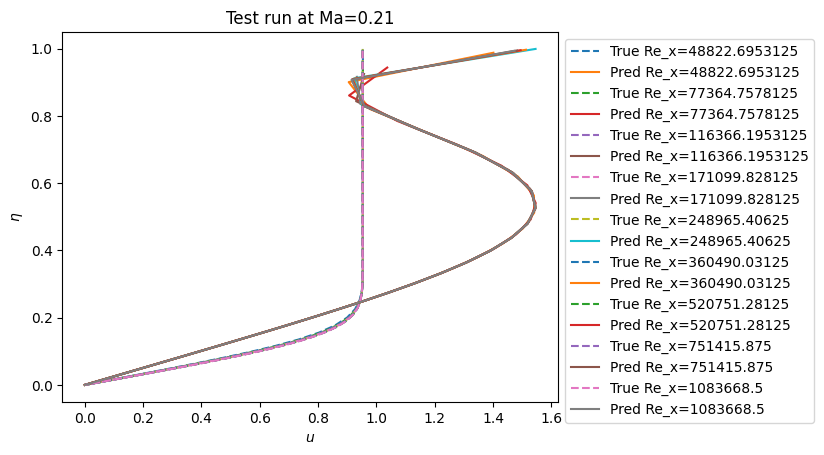

In [10]:
# evaluate the model with the test data

for idx in index_test_run:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"True Re_x={re_x}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Pred Re_x={re_x}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.title('Test run at Ma=0.21')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()    

# Model with sparse weights, reduce overfitting
134510

Running on cuda
Fold 1/10
Training on cuda
Epoch 1, Loss: 14.687078475952148
Epoch 2, Loss: 0.7483202815055847
Epoch 3, Loss: 24.944869995117188
Epoch 4, Loss: 73.88218688964844
Epoch 5, Loss: 236.5069122314453
Epoch 6, Loss: 33.06882095336914
Epoch 7, Loss: 0.5104646682739258
Epoch 8, Loss: 1.1693496704101562
Epoch 9, Loss: 1.347513198852539
Epoch 10, Loss: 2.697523832321167
Epoch 11, Loss: 14.213233947753906
Epoch 12, Loss: 157.2156524658203
Epoch 13, Loss: 2.9071974754333496
Epoch 14, Loss: 0.4154752492904663
Epoch 15, Loss: 0.5415230989456177
Epoch 16, Loss: 0.870356559753418
Epoch 17, Loss: 0.9659820795059204
Epoch 18, Loss: 90.55855560302734
Epoch 19, Loss: 353.9815979003906
Epoch 20, Loss: 0.5455604791641235
Epoch 21, Loss: 61.57141876220703
Epoch 22, Loss: 12.111625671386719
Epoch 23, Loss: 1245.4512939453125
Epoch 24, Loss: 7.210982322692871
Epoch 25, Loss: 0.7264301180839539
Epoch 26, Loss: 1.907684564590454
Epoch 27, Loss: 4.075472354888916
Epoch 28, Loss: 22.532920837402344

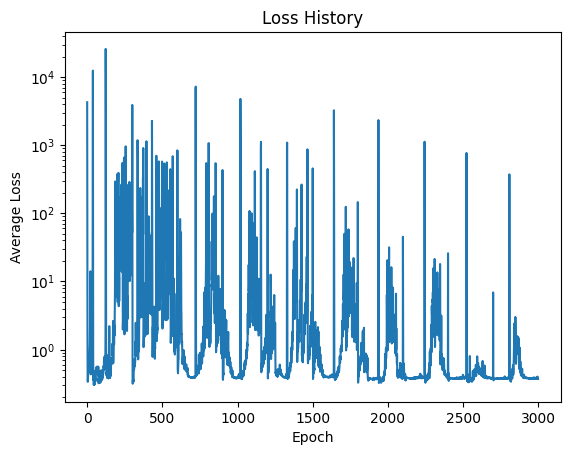

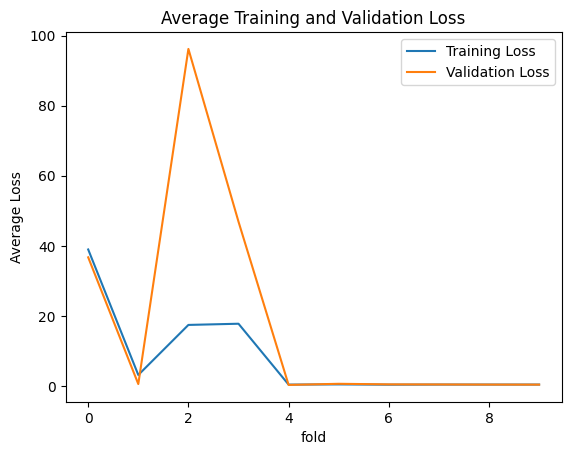

/tmp/ipykernel_11561/3554236546.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model2.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
/home/yiren/Desktop/blasius_ANN/CANN.py:241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Re_x = torch.tensor(Re_x, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/CANN.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dp_dx = torch.tensor(dp_dx, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/

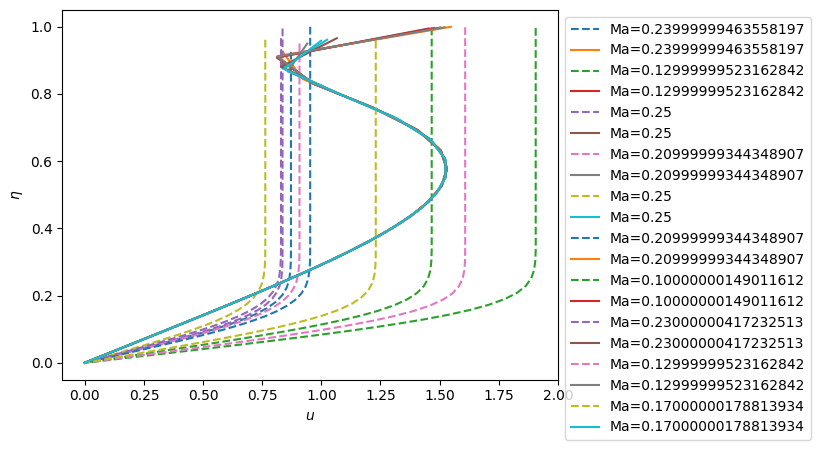

TypeError: CANN.evaluate() takes 2 positional arguments but 3 were given

In [11]:
# define training params 
num_cv_folds = 10
epochs = 3000
learning_rate = 20e-1
step_size = 150
gamma = 0.9
prune_iter = 150
to_prune = True

# define model parameters 
alpha=20e-3
beta = 1
prune_threshold_min=1e-3
prune_threshold_max=1e3

torch.seed = 3407
model2 = CANN(alpha=alpha, beta=beta, prune_threshold_min=prune_threshold_min, prune_threshold_max=prune_threshold_max)
# train the model with cross validation (k-fold cross validation
los_history2, train_ave_loss2, val_ave_loss2 = model2.train_with_cross_validation(dataset, num_folds=num_cv_folds, \
                                                                               epochs=epochs, learning_rate=learning_rate, \
                                                                                step_size=step_size, gamma=gamma, \
                                                                                to_prune=to_prune, prune_iter=prune_iter)

trained_weights2, trained_biases2 = model2.get_weights()
print('Trained weights:')
print(trained_weights2)
print('Trained biases:')
print(trained_biases2)
# save the model
cur_date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
torch.save(model2.state_dict(), f"trained_model_{cur_date_time}.pth")
# save the loss history
np.save(f"loss_history_{cur_date_time}.npy", los_history2)
np.save(f"train_ave_loss_{cur_date_time}.npy", train_ave_loss2)
np.save(f"val_ave_loss_{cur_date_time}.npy", val_ave_loss2)
# save the weights and biases
for i, weights in enumerate(trained_weights2):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", weights)
for i, bias in enumerate(trained_biases2):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", bias)

# save dataset
with open('dataset.pkl', 'wb') as f:
    pickle.dump(input_data, f)

# flatting loss history into 1d array 
los_history_flatten = [item for sublist in los_history for item in sublist]

# Plotting the loss history
plt.plot(los_history_flatten)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.yscale('log')
plt.savefig(f"loss_history_{cur_date_time}.png")
plt.show()

# Plotting the average training and validation loss
plt.plot(train_ave_loss2, label='Training Loss')
plt.plot(val_ave_loss2, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('fold')
plt.ylabel('Average Loss')
plt.legend()
plt.savefig(f"train_val_loss_{cur_date_time}.png")
plt.show()

# randomly select some 10 data from the dataset to evaluate the model
num_data = 10
np.random.seed(3407)
random_indices = np.random.choice(len(dataset), num_data, replace=False)
for idx in random_indices:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model2.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"Ma={mach}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Ma={mach}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()  


# evaluate the model with the test data
for idx in index_test_run:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model2.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"True Re_x={re_x}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Pred Re_x={re_x}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.title('Test run at Ma=0.21')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()      

/tmp/ipykernel_11561/2795009301.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model2.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))


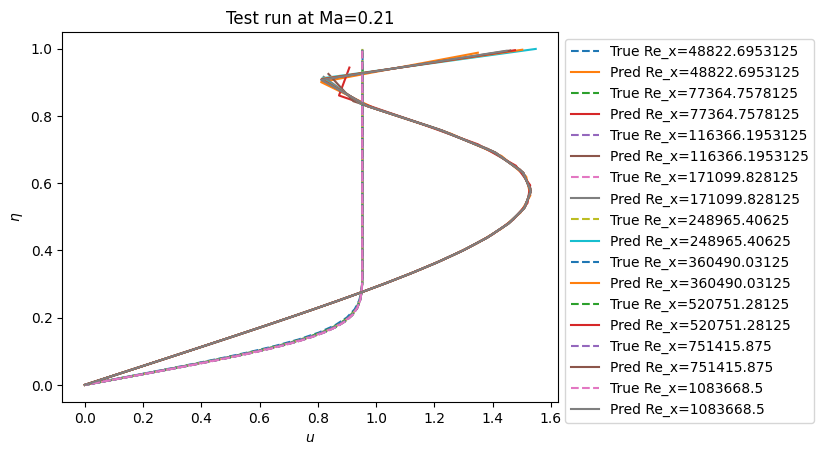

In [12]:
# evaluate the model with the test data
for idx in index_test_run:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model2.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"True Re_x={re_x}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Pred Re_x={re_x}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.title('Test run at Ma=0.21')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()     

# test 3 change beta to have more MSE loss 
141240

Running on cuda
Fold 1/10
Training on cuda
Epoch 1, Loss: 1505.4078369140625
Epoch 2, Loss: 34.1382942199707
Epoch 3, Loss: 2.1702160835266113
Epoch 4, Loss: 1.399498462677002
Epoch 5, Loss: 1.4469674825668335
Epoch 6, Loss: 1.1315182447433472
Epoch 7, Loss: 1.6488994359970093
Epoch 8, Loss: 1.5189146995544434
Epoch 9, Loss: 1.7757526636123657
Epoch 10, Loss: 1.1392892599105835
Epoch 11, Loss: 1.1077537536621094
Epoch 12, Loss: 1.0784645080566406
Epoch 13, Loss: 1.634307861328125
Epoch 14, Loss: 1.7416677474975586
Epoch 15, Loss: 1.918905258178711
Epoch 16, Loss: 1.7137625217437744
Epoch 17, Loss: 1.6825969219207764
Epoch 18, Loss: 1.3833820819854736
Epoch 19, Loss: 1.6687077283859253
Epoch 20, Loss: 0.9490867257118225
Epoch 21, Loss: 1.243382453918457
Epoch 22, Loss: 8.301009178161621
Epoch 23, Loss: 2.153668165206909
Epoch 24, Loss: 36.837223052978516
Epoch 25, Loss: 120.98185729980469
Epoch 26, Loss: 6.849024295806885
Epoch 27, Loss: 1.148941993713379
Epoch 28, Loss: 0.9596022367477

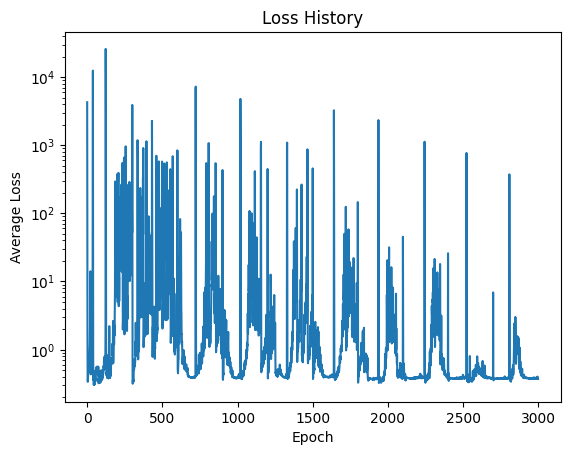

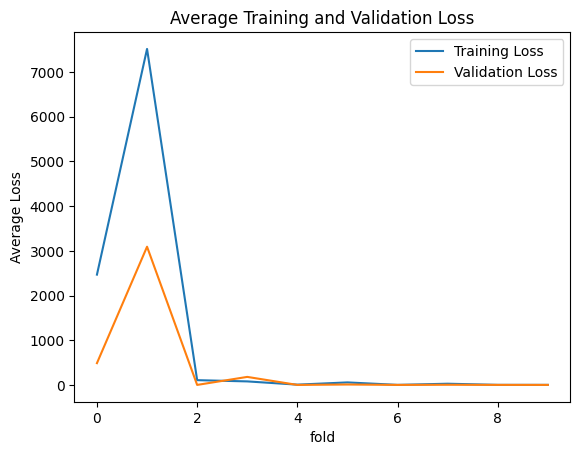

/tmp/ipykernel_11561/1380496074.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model3.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
/home/yiren/Desktop/blasius_ANN/CANN.py:241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Re_x = torch.tensor(Re_x, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/CANN.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dp_dx = torch.tensor(dp_dx, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/

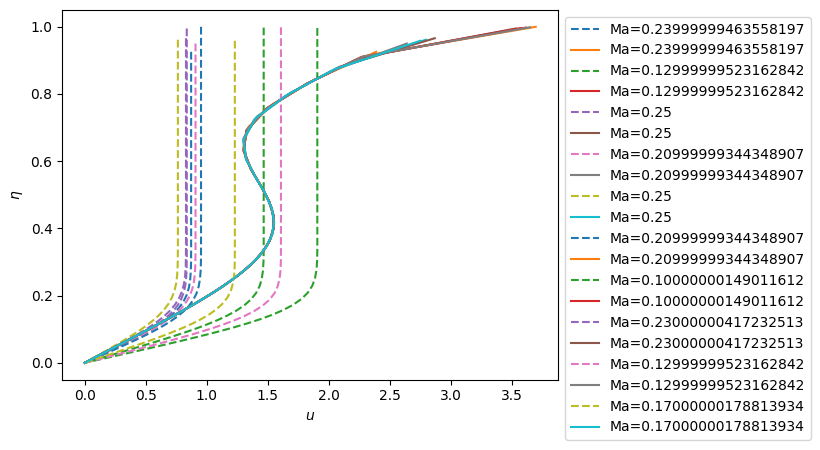

/tmp/ipykernel_11561/1380496074.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model3.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))


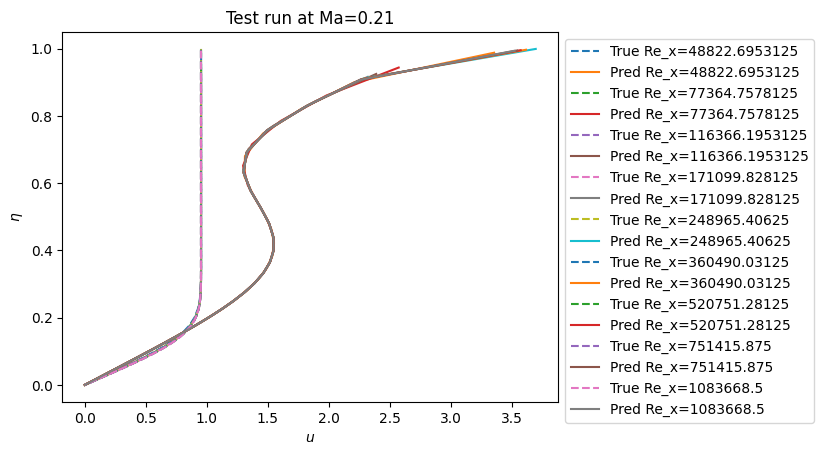

In [13]:
# define training params 
num_cv_folds = 10
epochs = 3000
learning_rate = 20e-1
step_size = 150
gamma = 0.9
prune_iter = 150
to_prune = True

# define model parameters 
alpha=20e-3
beta = 10
prune_threshold_min=1e-3
prune_threshold_max=1e3

torch.seed = 3407
model3 = CANN(alpha=alpha, beta=beta, prune_threshold_min=prune_threshold_min, prune_threshold_max=prune_threshold_max)
# train the model with cross validation (k-fold cross validation
los_history3, train_ave_loss3, val_ave_loss3 = model3.train_with_cross_validation(dataset, num_folds=num_cv_folds, \
                                                                               epochs=epochs, learning_rate=learning_rate, \
                                                                                step_size=step_size, gamma=gamma, \
                                                                                to_prune=to_prune, prune_iter=prune_iter)

trained_weights3, trained_biases3 = model3.get_weights()
print('Trained weights:')
print(trained_weights3)
print('Trained biases:')
print(trained_biases3)
# save the model
cur_date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
torch.save(model2.state_dict(), f"trained_model_{cur_date_time}.pth")
# save the loss history
np.save(f"loss_history_{cur_date_time}.npy", los_history3)
np.save(f"train_ave_loss_{cur_date_time}.npy", train_ave_loss3)
np.save(f"val_ave_loss_{cur_date_time}.npy", val_ave_loss3)
# save the weights and biases
for i, weights in enumerate(trained_weights3):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", weights)
for i, bias in enumerate(trained_biases3):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", bias)

# save dataset
with open('dataset.pkl', 'wb') as f:
    pickle.dump(input_data, f)

# flatting loss history into 1d array 
los_history_flatten = [item for sublist in los_history for item in sublist]

# Plotting the loss history
plt.plot(los_history_flatten)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.yscale('log')
plt.savefig(f"loss_history_{cur_date_time}.png")
plt.show()

# Plotting the average training and validation loss
plt.plot(train_ave_loss3, label='Training Loss')
plt.plot(val_ave_loss3, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('fold')
plt.ylabel('Average Loss')
plt.legend()
plt.savefig(f"train_val_loss_{cur_date_time}.png")
plt.show()

# randomly select some 10 data from the dataset to evaluate the model
num_data = 10
np.random.seed(3407)
random_indices = np.random.choice(len(dataset), num_data, replace=False)
for idx in random_indices:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model3.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"Ma={mach}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Ma={mach}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()  


# evaluate the model with the test data
for idx in index_test_run:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model3.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"True Re_x={re_x}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Pred Re_x={re_x}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.title('Test run at Ma=0.21')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()      

# further add regularization to remove high order oscillation
increase prune threshold min from 1e-3 to 5e-3
increase alpha from 20e-3 to 20e-2

Running on cuda
Fold 1/10
Training on cuda
Epoch 1, Loss: 2211.985595703125
Epoch 2, Loss: 9.937304496765137
Epoch 3, Loss: 2.9264492988586426
Epoch 4, Loss: 2.103182315826416
Epoch 5, Loss: 1.717393398284912
Epoch 6, Loss: 1.180161476135254
Epoch 7, Loss: 1.465743899345398
Epoch 8, Loss: 0.8162707686424255
Epoch 9, Loss: 0.9157508015632629
Epoch 10, Loss: 1.7484053373336792
Epoch 11, Loss: 5.545980453491211
Epoch 12, Loss: 1.4764978885650635
Epoch 13, Loss: 5.676704406738281
Epoch 14, Loss: 2.1205101013183594
Epoch 15, Loss: 3.1519670486450195
Epoch 16, Loss: 7.0497541427612305
Epoch 17, Loss: 1.3611042499542236
Epoch 18, Loss: 1.4596669673919678
Epoch 19, Loss: 1.5190554857254028
Epoch 20, Loss: 1.1662523746490479
Epoch 21, Loss: 1.0112886428833008
Epoch 22, Loss: 1.6207966804504395
Epoch 23, Loss: 3.9841480255126953
Epoch 24, Loss: 1.2160497903823853
Epoch 25, Loss: 1.0703535079956055
Epoch 26, Loss: 2.6745715141296387
Epoch 27, Loss: 1.49003005027771
Epoch 28, Loss: 1.2958685159683

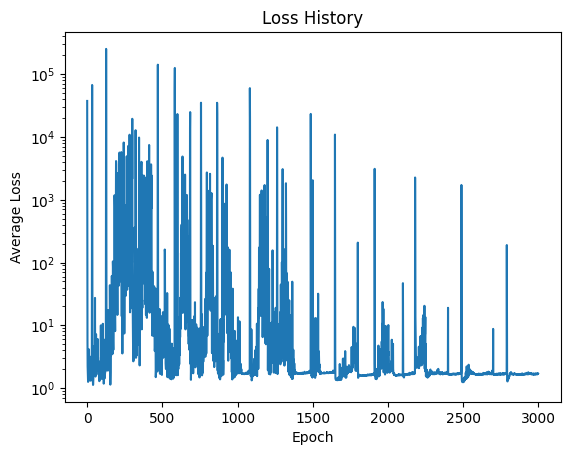

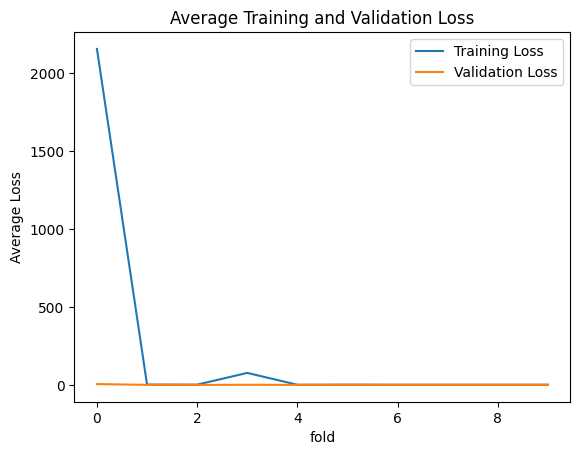

/tmp/ipykernel_11561/1571842358.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model4.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
/home/yiren/Desktop/blasius_ANN/CANN.py:241: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Re_x = torch.tensor(Re_x, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/CANN.py:242: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dp_dx = torch.tensor(dp_dx, dtype=torch.float32).unsqueeze(0)
/home/yiren/Desktop/blasius_ANN/

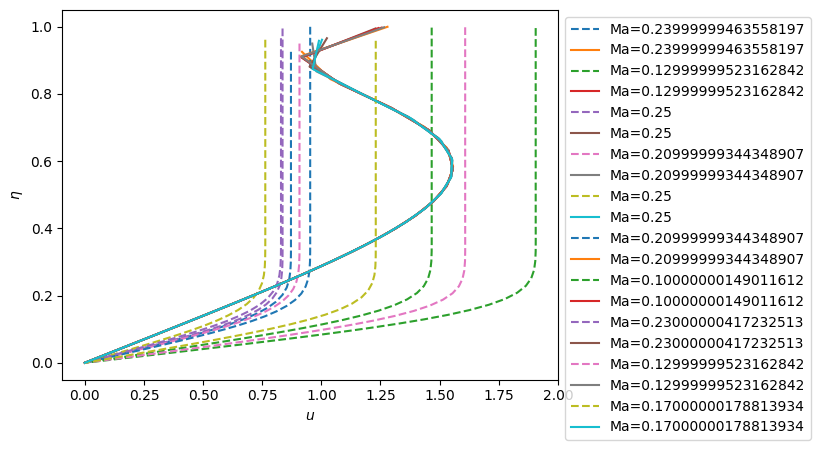

/tmp/ipykernel_11561/1571842358.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model4.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))


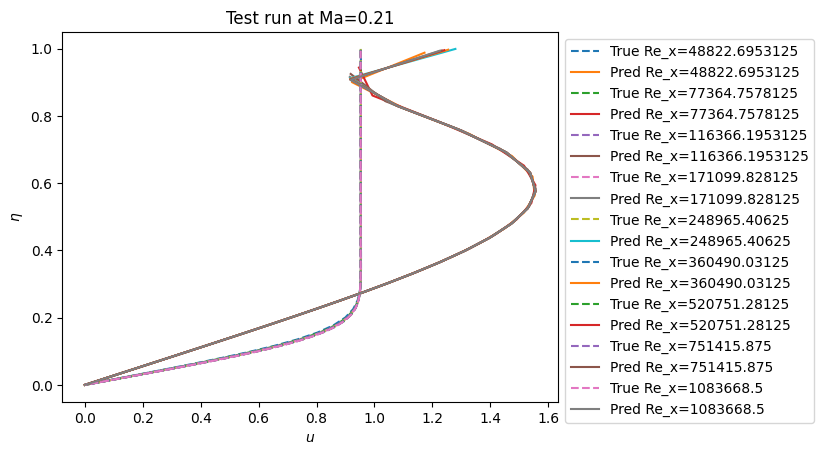

In [15]:
# define training params 
num_cv_folds = 10
epochs = 3000
learning_rate = 20e-1
step_size = 150
gamma = 0.9
prune_iter = 150
to_prune = True

# define model parameters 
alpha=20e-2
beta = 10
prune_threshold_min=1e-3
prune_threshold_max=1e3

torch.seed = 3407
model4 = CANN(alpha=alpha, beta=beta, prune_threshold_min=prune_threshold_min, prune_threshold_max=prune_threshold_max)
# train the model with cross validation (k-fold cross validation
los_history4, train_ave_loss4, val_ave_loss4 = model4.train_with_cross_validation(dataset, num_folds=num_cv_folds, \
                                                                               epochs=epochs, learning_rate=learning_rate, \
                                                                                step_size=step_size, gamma=gamma, \
                                                                                to_prune=to_prune, prune_iter=prune_iter)

trained_weights4, trained_biases4 = model4.get_weights()
print('Trained weights:')
print(trained_weights4)
print('Trained biases:')
print(trained_biases4)
# save the model
cur_date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
torch.save(model4.state_dict(), f"trained_model_{cur_date_time}.pth")
# save the loss history
np.save(f"loss_history_{cur_date_time}.npy", los_history4)
np.save(f"train_ave_loss_{cur_date_time}.npy", train_ave_loss4)
np.save(f"val_ave_loss_{cur_date_time}.npy", val_ave_loss4)
# save the weights and biases
for i, weights in enumerate(trained_weights4):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", weights)
for i, bias in enumerate(trained_biases4):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", bias)

# save dataset
with open('dataset.pkl', 'wb') as f:
    pickle.dump(input_data, f)

# flatting loss history into 1d array 
los_history_flatten = [item for sublist in los_history4 for item in sublist]

# Plotting the loss history
plt.plot(los_history_flatten)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.yscale('log')
plt.savefig(f"loss_history_{cur_date_time}.png")
plt.show()

# Plotting the average training and validation loss
plt.plot(train_ave_loss4, label='Training Loss')
plt.plot(val_ave_loss4, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('fold')
plt.ylabel('Average Loss')
plt.legend()
plt.savefig(f"train_val_loss_{cur_date_time}.png")
plt.show()

# randomly select some 10 data from the dataset to evaluate the model
num_data = 10
np.random.seed(3407)
random_indices = np.random.choice(len(dataset), num_data, replace=False)
for idx in random_indices:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model4.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"Ma={mach}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Ma={mach}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()  


# evaluate the model with the test data
for idx in index_test_run:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model4.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"True Re_x={re_x}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Pred Re_x={re_x}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.title('Test run at Ma=0.21')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()      

# further adjust regularization


Running on cuda
Fold 1/6
Training on cuda
Epoch 1, Loss: 4.490469932556152
Epoch 2, Loss: 2.468834400177002
Epoch 3, Loss: 0.35193589329719543
Epoch 4, Loss: 0.267263799905777
Epoch 5, Loss: 0.5649711489677429
Epoch 6, Loss: 0.49201101064682007
Epoch 7, Loss: 1.0876857042312622
Epoch 8, Loss: 1.1266298294067383
Epoch 9, Loss: 3.67303466796875
Epoch 10, Loss: 2.184175968170166
Epoch 11, Loss: 0.3445916175842285
Epoch 12, Loss: 0.5992301106452942
Epoch 13, Loss: 1.5643874406814575
Epoch 14, Loss: 1.1904011964797974
Epoch 15, Loss: 1.2864735126495361
Epoch 16, Loss: 0.4685135781764984
Epoch 17, Loss: 0.9148023128509521
Epoch 18, Loss: 0.2708602547645569
Epoch 19, Loss: 0.2275904417037964
Epoch 20, Loss: 0.3170475363731384
Epoch 21, Loss: 0.369663268327713
Epoch 22, Loss: 6.327049732208252
Epoch 23, Loss: 3.2547390460968018
Epoch 24, Loss: 0.4589073956012726
Epoch 25, Loss: 0.33600977063179016
Epoch 26, Loss: 0.6972516179084778
Epoch 27, Loss: 0.47639378905296326
Epoch 28, Loss: 1.10025489

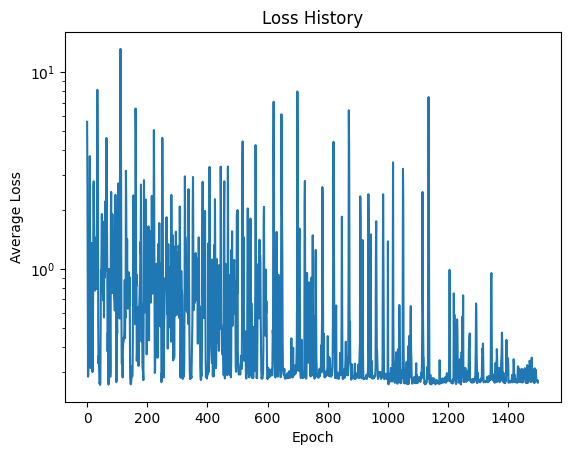

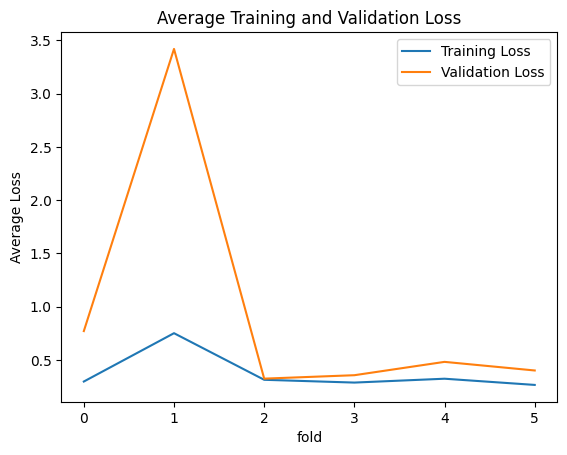

/tmp/ipykernel_11561/2543012595.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model5.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))


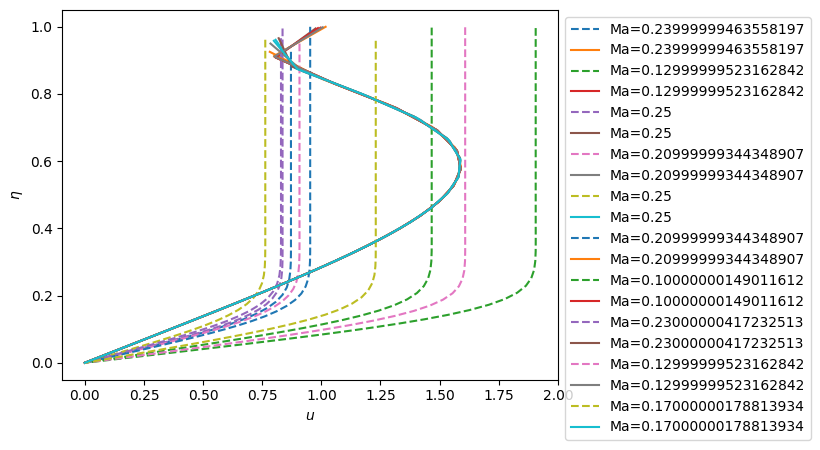

/tmp/ipykernel_11561/2543012595.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model5.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))


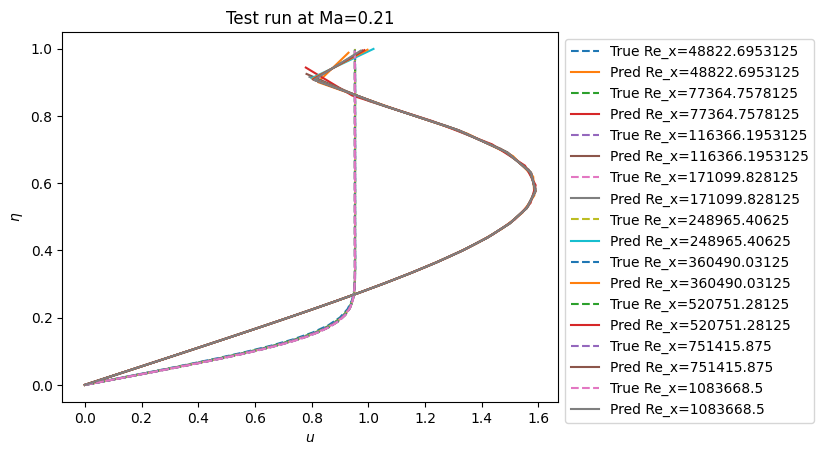

In [31]:
# define training params 
num_cv_folds = 6
epochs = 1500
learning_rate = 10e-1
step_size = 150
gamma = 0.9
prune_iter = 150
to_prune = True

# define model parameters 
alpha=2e-2
beta = 0
prune_threshold_min=1e-2
prune_threshold_max=1e2

torch.seed = 3407
model5 = CANN(alpha=alpha, beta=beta, prune_threshold_min=prune_threshold_min, prune_threshold_max=prune_threshold_max)
# train the model with cross validation (k-fold cross validation
los_history5, train_ave_loss5, val_ave_loss5 = model5.train_with_cross_validation(dataset, num_folds=num_cv_folds, \
                                                                               epochs=epochs, learning_rate=learning_rate, \
                                                                                step_size=step_size, gamma=gamma, \
                                                                                to_prune=to_prune, prune_iter=prune_iter)

trained_weights5, trained_biases5 = model5.get_weights()
print('Trained weights:')
print(trained_weights5)
print('Trained biases:')
print(trained_biases5)
# save the model
cur_date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
torch.save(model5.state_dict(), f"trained_model_{cur_date_time}.pth")
# save the loss history
np.save(f"loss_history_{cur_date_time}.npy", los_history5)
np.save(f"train_ave_loss_{cur_date_time}.npy", train_ave_loss5)
np.save(f"val_ave_loss_{cur_date_time}.npy", val_ave_loss5)
# save the weights and biases
for i, weights in enumerate(trained_weights5):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", weights)
for i, bias in enumerate(trained_biases5):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", bias)

# save dataset
with open('dataset.pkl', 'wb') as f:
    pickle.dump(input_data, f)

# flatting loss history into 1d array 
los_history_flatten = [item for sublist in los_history5 for item in sublist]

# Plotting the loss history
plt.plot(los_history_flatten)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.yscale('log')
plt.savefig(f"loss_history_{cur_date_time}.png")
plt.show()

# Plotting the average training and validation loss
plt.plot(train_ave_loss5, label='Training Loss')
plt.plot(val_ave_loss5, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('fold')
plt.ylabel('Average Loss')
plt.legend()
plt.savefig(f"train_val_loss_{cur_date_time}.png")
plt.show()

# randomly select some 10 data from the dataset to evaluate the model
num_data = 10
np.random.seed(3407)
random_indices = np.random.choice(len(dataset), num_data, replace=False)
for idx in random_indices:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model5.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"Ma={mach}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Ma={mach}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()  


# evaluate the model with the test data
for idx in index_test_run:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model5.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"True Re_x={re_x}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Pred Re_x={re_x}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.title('Test run at Ma=0.21')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()      

further reduce variance 

Running on cuda
Fold 1/4
Training on cuda
Epoch 1, Loss: 22.584436416625977
Epoch 2, Loss: 2.475987195968628
Epoch 3, Loss: 3.3312907218933105
Epoch 4, Loss: 3.5757906436920166
Epoch 5, Loss: 3.6252336502075195
Epoch 6, Loss: 5.08689546585083
Epoch 7, Loss: 5.461301803588867
Epoch 8, Loss: 5.736160755157471
Epoch 9, Loss: 5.288783550262451
Epoch 10, Loss: 4.271450042724609
Epoch 11, Loss: 5.170742034912109
Epoch 12, Loss: 5.3459248542785645
Epoch 13, Loss: 3.9496817588806152
Epoch 14, Loss: 3.9674525260925293
Epoch 15, Loss: 4.016902446746826
Epoch 16, Loss: 4.5680341720581055
Epoch 17, Loss: 5.397165298461914
Epoch 18, Loss: 3.315084457397461
Epoch 19, Loss: 5.050471782684326
Epoch 20, Loss: 4.081981658935547
Epoch 21, Loss: 6.105762481689453
Epoch 22, Loss: 2.2749481201171875
Epoch 23, Loss: 3.6979169845581055
Epoch 24, Loss: 4.768756866455078
Epoch 25, Loss: 5.595699310302734
Epoch 26, Loss: 6.7294816970825195
Epoch 27, Loss: 3.493619203567505
Epoch 28, Loss: 4.71369743347168
Epoch 

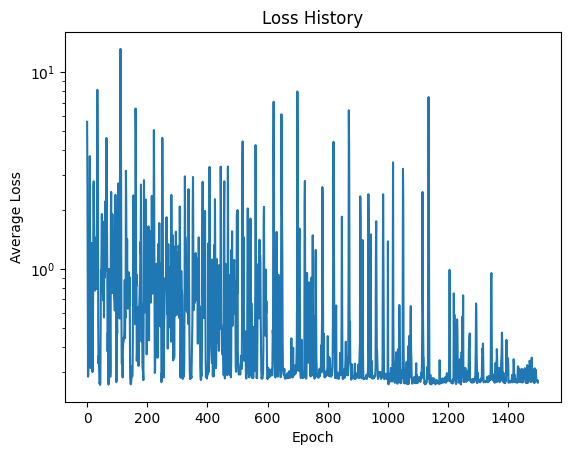

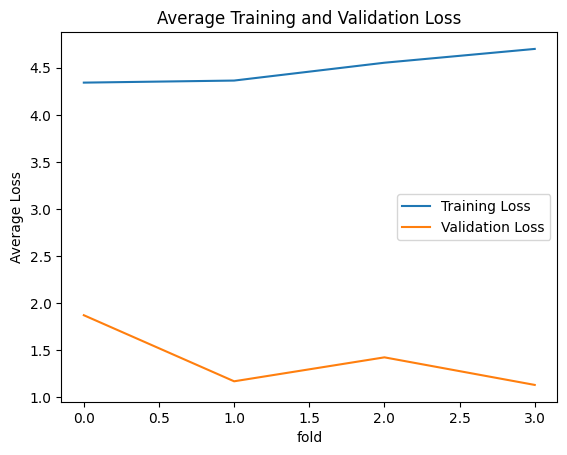

/tmp/ipykernel_11561/1507141656.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model6.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))


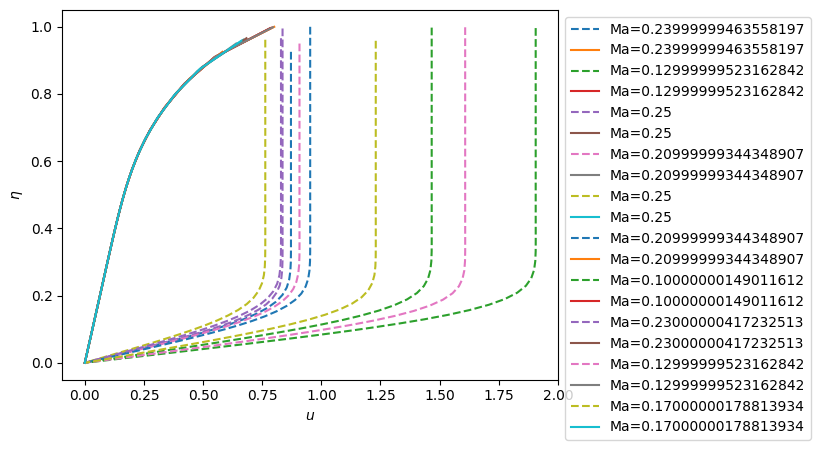

/tmp/ipykernel_11561/1507141656.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model6.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))


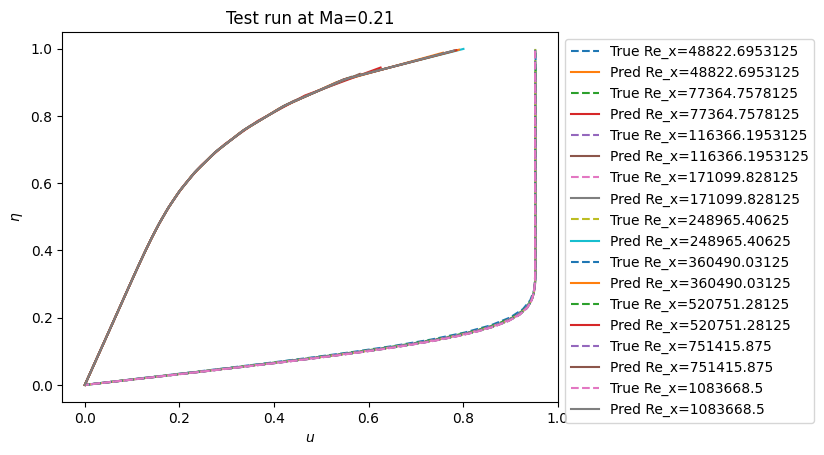

In [72]:
# define training params 
num_cv_folds = 4
epochs = 1200
learning_rate = 10e-1
step_size = 150
gamma = 0.9
prune_iter = 150
to_prune = True

# define model parameters 
alpha= 10
beta = 5
prune_threshold_min=5e-3
prune_threshold_max=1e2

torch.seed = 16
model6 = CANN(alpha=alpha, beta=beta, prune_threshold_min=prune_threshold_min, prune_threshold_max=prune_threshold_max)
# train the model with cross validation (k-fold cross validation
los_history6, train_ave_loss6, val_ave_loss6 = model6.train_with_cross_validation(dataset, num_folds=num_cv_folds, \
                                                                               epochs=epochs, learning_rate=learning_rate, \
                                                                                step_size=step_size, gamma=gamma, \
                                                                                to_prune=to_prune, prune_iter=prune_iter)

trained_weights6, trained_biases6 = model6.get_weights()
print('Trained weights:')
print(trained_weights6)
print('Trained biases:')
print(trained_biases6)
# save the model
cur_date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
torch.save(model5.state_dict(), f"trained_model_{cur_date_time}.pth")
# save the loss history
np.save(f"loss_history_{cur_date_time}.npy", los_history6)
np.save(f"train_ave_loss_{cur_date_time}.npy", train_ave_loss6)
np.save(f"val_ave_loss_{cur_date_time}.npy", val_ave_loss6)
# save the weights and biases
for i, weights in enumerate(trained_weights6):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", weights)
for i, bias in enumerate(trained_biases6):
    np.save(f"trained_weights_{cur_date_time}_{i}.npy", bias)

# save dataset
with open('dataset.pkl', 'wb') as f:
    pickle.dump(input_data, f)

# flatting loss history into 1d array 
los_history_flatten = [item for sublist in los_history5 for item in sublist]

# Plotting the loss history
plt.plot(los_history_flatten)
plt.title('Loss History')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.yscale('log')
plt.savefig(f"loss_history_{cur_date_time}.png")
plt.show()

# Plotting the average training and validation loss
plt.plot(train_ave_loss6, label='Training Loss')
plt.plot(val_ave_loss6, label='Validation Loss')
plt.title('Average Training and Validation Loss')
plt.xlabel('fold')
plt.ylabel('Average Loss')
plt.legend()
plt.savefig(f"train_val_loss_{cur_date_time}.png")
plt.show()

# randomly select some 10 data from the dataset to evaluate the model
num_data = 10
np.random.seed(3407)
random_indices = np.random.choice(len(dataset), num_data, replace=False)
for idx in random_indices:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model6.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"Ma={mach}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Ma={mach}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()  


# evaluate the model with the test data
for idx in index_test_run:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model6.eval_prediction(re_x, dp_dx, mach, pr_lam, torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"True Re_x={re_x}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Pred Re_x={re_x}", linestyle='-')
plt.xlabel('$u$')
plt.ylabel('$\eta$')
plt.title('Test run at Ma=0.21')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()      

/tmp/ipykernel_11561/2058334274.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predicted_dy_deta = model6.eval_prediction(re_x, 1e-3, 1e-3, pr_lam, 1.1*torch.tensor(eta, dtype=torch.float32).unsqueeze(0))


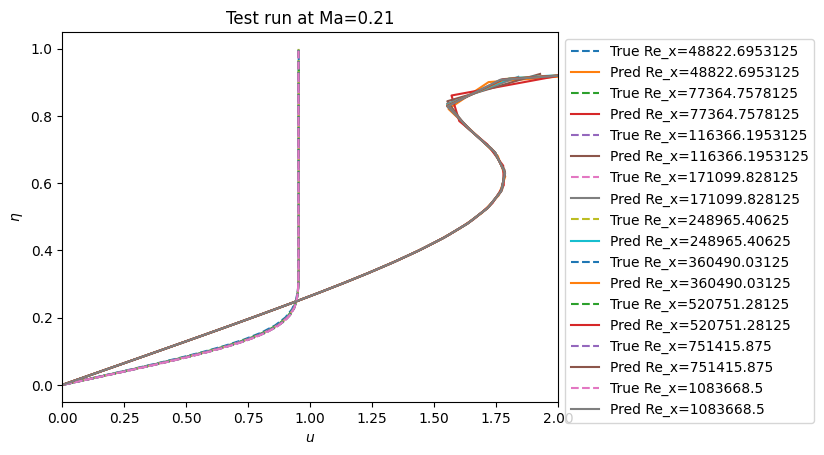

In [70]:

# evaluate the model with the test data
for idx in index_test_run:
    ff_conditions, eta, u = dataset[idx]
    re_x, dp_dx, mach, pr_lam = ff_conditions
    predicted_dy_deta = model6.eval_prediction(re_x, 1e-3, 1e-3, pr_lam, 1.1*torch.tensor(eta, dtype=torch.float32).unsqueeze(0))
    plt.plot(u, eta, label=f"True Re_x={re_x}", linestyle='--')
    plt.plot(predicted_dy_deta.cpu().detach().numpy().squeeze(), eta, label=f"Pred Re_x={re_x}", linestyle='-')
plt.xlabel('$u$')
plt.xlim(0, 2)
plt.ylabel('$\eta$')
plt.title('Test run at Ma=0.21')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()      